In [1]:
# imports
import torch
from torch.distributions import Normal
import matplotlib.pyplot as plt
import matplotlib.patheffects as mpe
from functools import partial
from copy import deepcopy
import sys
from pathlib import Path

# change import path
path = Path.cwd().parents[1]
if str(path) not in sys.path:
    sys.path.append(str(path))

from src.BayesIMP import *
from src.causalKLGP import *
from src.baselineGP import *
from src.kernels import *
from src.GP_utils import *
from src.kernel_utils import *
from src.dgps import *

### Drawing data

In [3]:
# DGP set up
d = 5
train_samples = 100
test_samples = 100
noise_variance = 0.5
doAlower = 0
doAupper = 1
mc_samples_EYdoZ = 10**4

# PLotting settings
z_val = 1.96

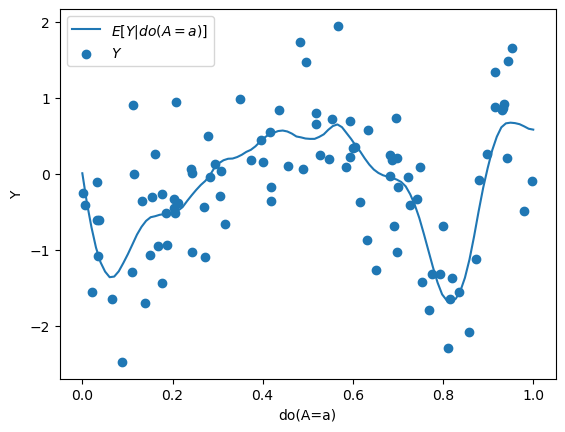

In [5]:
# Dataset generation and plotting E[Y|do(A)]
#torch.random.manual_seed(1), d=4, noise_var = 0.5 # BASE SETTINGS
A,V,Y,doA, YdoA, EYdoA =  Abelation(train_samples, test_samples, d, noise_variance, doAlower, doAupper, mc_samples_EYdoZ,seed = 0)

# Plot
indices = torch.argsort(doA,0)[:,0]
indices_train = torch.argsort(A,0)[:,0]
plt.plot(doA[indices],-EYdoA[indices], label = r"$ E[Y|do(A=a)]$")
plt.scatter(A,-Y, label = r"$Y$")
plt.xlabel("do(A=a)")
plt.ylabel("Y")
plt.legend()
plt.show()

# causalKLGP

In [7]:
"""Initialising model"""
model = causalKLGP(Kernel_A = GaussianKernel, 
                   Kernel_V = GaussianKernel, 
                   dim_A = A.size()[1], 
                   dim_V = V.size()[1], 
                   samples = 10**5)

""" Calibrating model """
niter = 500
learn_rate = 0.1
cal_latent = True
traincalmodel = False

nulist = 2**torch.linspace(-5,5,11)
levels = torch.tensor([0.1,0.3,0.5,0.7,0.9])

In [8]:
""" Training full model """
model.train(Y,A,V,niter,learn_rate)

iter 0 P(Y|V) loss:  tensor(35.6502)
iter 100 P(Y|V) loss:  tensor(5.1672)
iter 200 P(Y|V) loss:  tensor(5.0248)
iter 300 P(Y|V) loss:  tensor(4.9869)
iter 400 P(Y|V) loss:  tensor(4.9750)
iter 0 P(V|A) loss:  tensor(20.9045)
iter 100 P(V|A) loss:  tensor(-4.3086)
iter 200 P(V|A) loss:  tensor(-4.3091)
iter 300 P(V|A) loss:  tensor(-4.3091)
iter 400 P(V|A) loss:  tensor(-4.3090)


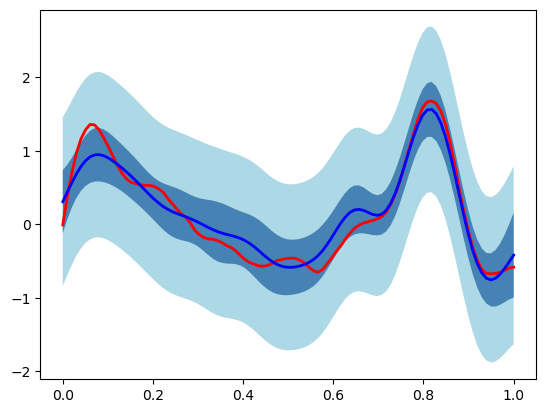

In [15]:
# getting post mean predictions
causalklgp = deepcopy(model)
causalklgp_mu = causalklgp.post_mean(Y, A, V, doA).detach()
causalklgp_var = causalklgp.post_var(Y, A, V,doA, reg = 1e-4, latent = True, nu =1).detach()
causalklgp_var_noise = causalklgp.post_var(Y, A, V, doA, reg = 1e-4, latent = False, nu = 1).detach()

# Getting CI
indices = torch.argsort(doA,0)[:,0]
indices_train = torch.argsort(A,0)[:,0]
Upper = (causalklgp_mu[indices]+z_val*torch.sqrt(causalklgp_var[indices]))
Lower = (causalklgp_mu[indices]-z_val*torch.sqrt(causalklgp_var[indices]))
Upper_noise = (causalklgp_mu[indices]+z_val*torch.sqrt(causalklgp_var_noise[indices]))
Lower_noise = (causalklgp_mu[indices]-z_val*torch.sqrt(causalklgp_var_noise[indices]))

plt.plot(doA[indices],EYdoA[indices], label = r"$ E[Y|do(A)]$", color = "red", linewidth = 2)
plt.plot(doA[indices],causalklgp_mu[indices], label = r"causalKLGP", color = "blue", linewidth = 2)
plt.fill_between(doA[indices][:,0],Upper_noise[:,0],Lower_noise[:,0], color = "lightblue",alpha=1, edgecolor='none', label = "95% CI")
plt.fill_between(doA[indices][:,0],Upper[:,0],Lower[:,0], color = "steelblue",alpha=1, edgecolor='none', label = "95% CI")

In [21]:
""" Nystrom sampling """

self = model
nu = 1.0
samples = 10000
features = 100
reg = 1e-4
### NOT COMPATIBLE WITH TWO DATASETS OR AVERAGING
    
# Set up
n = len(Y)
Y = Y.reshape(n,1)
ntest = len(doA)

# Updating nuclear dominant kernel
self.kernel_V.dist.scale = nu*V.var(0)**0.5
self.kernel_V.dist.loc = V.mean(0)

# Getting gram matrices
U = self.kernel_V.dist.sample((samples,)).detach()
K_uu = self.kernel_V.get_gram_base(U,U).detach()
K_vu = self.kernel_V.get_gram_base(V,U).detach()
K_vv = self.kernel_V.get_gram_base(V,V).detach()
K_aa = self.kernel_A.get_gram(A,A).detach()

# Getting eignefunctions and eigenvalues
eigs,vecs = torch.linalg.eig(K_uu/samples)
eigs,vecs = eigs.real.abs(), vecs.real

# Extending to datapoints
Phi_v = samples**-0.5*K_vu @ (vecs / eigs)
Phi_v_tilde = (Phi_v @ eigs.diag()**0.5)[:,:features]
Phi_v_tilde2 = (Phi_v @ eigs.diag())[:,:features]
eigs = eigs[:features]
Phi_v = Phi_v[:,:features]

# Getting moments of f
K_v = K_vv + (torch.exp(self.noise_Y)+reg)*torch.eye(n)
alpha_y = torch.linalg.solve(K_v,Y)
alpha_v = torch.linalg.solve(K_v, Phi_v_tilde2)
mu_f = (Phi_v_tilde2.T @ alpha_y).detach()  # nfeateres x 1
C_f = (eigs.diag() - Phi_v_tilde2.T @ alpha_v).detach() # nfeatures x nfeatures
C_f = 0.5*(C_f + C_f.T)
eigs_f,vecs_f = torch.linalg.eig(C_f)
eigs_f,vecs_f = eigs_f.real.abs(),vecs_f.real
C_fhalf = vecs_f @ eigs_f.diag()**0.5

# Getting moments of tilde phi_v
k_atesta = self.kernel_A.get_gram(doA,A).detach()
K_a = K_aa + (torch.exp(self.noise_feat)+reg)*torch.eye(n)
kpost_atest = GPpostvar(A, doA, self.kernel_A, torch.exp(self.noise_feat), latent = True).detach()
kpost_atest_noise = GPpostvar(A, doA, self.kernel_A, torch.exp(self.noise_feat), latent = False).detach()
mu_l = (Phi_v.T @ torch.linalg.solve(K_a,k_atesta.T)).detach()  # nfeatures x ntest 
C_l = kpost_atest.diag().detach() # ntest x 1 (dont need off-diagonals)
C_l_noise = kpost_atest_noise.diag().detach() # ntest x 1 (dont need off-diagonals)

# Getting samples of f
#F_s = MultivariateNormal(mu_f,C_f).sample((samples,)) # nsamples x ntest
epsilon = Normal(torch.zeros(features),torch.ones(features)).sample((samples,))
F_s = mu_f.T+epsilon @ C_fhalf.T # nsamples x nfeat
Phi_vs = Normal(mu_l,C_l).sample((samples,)) # nsamples x nfeat # ntest
Phi_vs_noise = Normal(mu_l,C_l_noise).sample((samples,)) # nsamples x nfeat # ntest
EYdoA_sample = (F_s[...,None]*Phi_vs).sum(1) # nsamples x ntest
YdoA_sample = (F_s[...,None]*Phi_vs_noise).sum(1) + Normal(0,torch.exp(self.noise_Y)**0.5).sample((samples,ntest)) # nsamples x ntest


KeyboardInterrupt: 

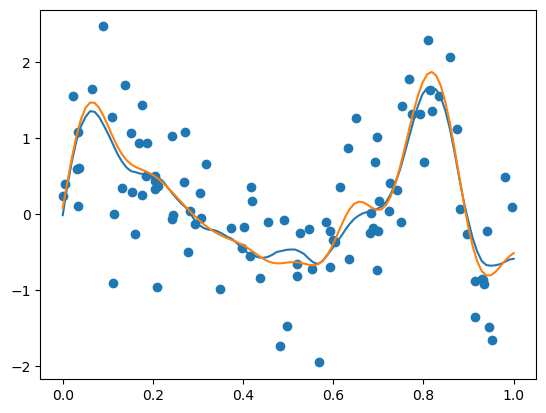

In [20]:
plt.plot(doA[indices],EYdoA[indices], label = r"$ E[Y|do(A=a)]$")
plt.scatter(A,Y, label = r"$Y$")
plt.plot(doA[indices],EYdoA_sample.mean(0))

In [ ]:
# Getting posterior moments and plotting results
power_list = torch.linspace(-2,2,3)
nulist = list(2**power_list)
nulist.append(nu_best)

fig,axs = plt.subplots(1,len(nulist),figsize = (18,5))

Causalklgp_mu = []
Causalklgp_var = []
Causalklgp_var_noise = []

for k in range(len(nulist)):
    
    # getting post mean predictions
    causalklgp = deepcopy(model)
    causalklgp_mu = causalklgp.post_mean(Y, A, V, doA).detach()
    causalklgp_var = causalklgp.post_var(Y, A, V, doA, reg = 1e-4, latent = True, nu = nulist[k]).detach()
    causalklgp_var_noise = causalklgp.post_var(Y, A, V, doA, reg = 1e-4, latent = False, nu = nulist[k]).detach()
    
    # Getting CI
    indices = torch.argsort(doA,0)[:,0]
    indices_train = torch.argsort(A,0)[:,0]
    Upper = (causalklgp_mu[indices]+z_val*torch.sqrt(causalklgp_var[indices]))
    Lower = (causalklgp_mu[indices]-z_val*torch.sqrt(causalklgp_var[indices]))
    Upper_noise = (causalklgp_mu[indices]+z_val*torch.sqrt(causalklgp_var_noise[indices]))
    Lower_noise = (causalklgp_mu[indices]-z_val*torch.sqrt(causalklgp_var_noise[indices]))
    print("nu = ", nulist[k])

    axs[k].plot(doA[indices],EYdoA[indices], label = r"$ E[Y|do(A)]$", color = "red", linewidth = 2)
    axs[k].plot(doA[indices],causalklgp_mu[indices], label = r"causalKLGP", color = "blue", linewidth = 2)
    axs[k].fill_between(doA[indices][:,0],Upper_noise[:,0],Lower_noise[:,0], color = "lightblue",alpha=1, edgecolor='none', label = "95% CI")
    axs[k].fill_between(doA[indices][:,0],Upper[:,0],Lower[:,0], color = "steelblue",alpha=1, edgecolor='none', label = "95% CI")
    #axs[k].scatter(doA[indices],YdoA[indices], label = r"$ Y|do(A)$", color = "grey", s=10, alpha = 1)
    axs[k].scatter(A,Y, s = 10, color = "black")
    axs[k].set_xlabel("do(A)")
    axs[k].set_ylabel("Y")
    if k != len(nulist)-1:
        axs[k].set_title("nu = " + str((2**power_list[k]).item())+" x sd(V)")
    else:
        axs[k].set_title("optimised nu")
        
    Causalklgp_mu.append(causalklgp_mu)
    Causalklgp_var.append(causalklgp_var.diag())
    Causalklgp_var_noise.append(causalklgp_var_noise.diag())

plt.legend()
plt.show()

In [ ]:
# Getting calibration plots
outline=mpe.withStroke(linewidth=4, foreground='black')
def _round(x, n):
    return int(x*10**n)/10**n

fig, axs = plt.subplots(1,2,figsize = (15,5))
levels = torch.linspace(0,1,21)[:,None]
nulist = 2**torch.linspace(-5,5,11)
z_quantiles = Normal(0, 1).icdf(1-(1-levels)/2)
axs[0].plot(levels, levels, ls = "dashed", color = "black")
axs[1].plot(levels, levels, ls = "dashed", color = "black")

for k in range(len(nulist)):
    
    # getting post mean predictions
    mean = causalklgp.post_mean(Y, A, V, doA).detach()
    var = causalklgp.post_var(Y, A, V, doA, reg = 1e-4, latent = True, nu = nulist[k]).detach()
    var_noise = causalklgp.post_var(Y, A, V, doA, reg = 1e-4, latent = False, nu = nulist[k]).detach()

    # Restricting to in sample distribution
    inds = ((doA[:,0]<=1)*(doA[:,0]>=0))
    
    posterior_fraction_f = ((EYdoA[inds] - mean[inds]).abs() <= var[inds]**0.5 @ z_quantiles.T).float().mean(0)
    posterior_fraction_y = ((YdoA[inds] - mean[inds]).abs() <= var_noise[inds]**0.5 @ z_quantiles.T).float().mean(0)
    rmse = ((EYdoA[inds] - mean[inds])**2).mean()**0.5

    axs[0].plot(levels,posterior_fraction_f, label = "nu = {0}, rmse = {1}".format(_round(nulist[k],3), _round(rmse,3)), lw = 2, path_effects = [outline]*(best_ind ==k))
    axs[1].plot(levels,posterior_fraction_y, label = "nu = {0}, rmse = {1}".format(_round(nulist[k],3), _round(rmse,3)),lw = 2 , path_effects = [outline]*(best_ind ==k))
    axs[0].legend()
    axs[1].legend()

In [ ]:
"""Initialising model"""
model_nystrom = causalKLGP(Kernel_A = GaussianKernel, 
                   Kernel_V = GaussianKernel, 
                   Kernel_Z = [],
                   dim_A = A.size()[1], 
                   dim_V = V.size()[1], 
                   samples = 10**5)

""" Calibrating model """
niter = 500
learn_rate = 0.1
cal_latent = True
traincalmodel = False
nystrom_features = 100
nystrom_samples = 1000

nulist = 2**torch.linspace(-5,5,11)
levels = torch.tensor([0.1,0.3,0.5,0.7,0.9])

Post_levels, Calibration_losses = model_nystrom.calibrate(Y, V, A, nulist, niter = niter, levels = levels, learn_rate = learn_rate, 
                                                    nystrom = True, nystrom_features = nystrom_features, nystrom_samples = nystrom_samples,
                                                  calibrate_latent = cal_latent, calibrate_norm = 1, train_calibration_model = traincalmodel)
best_ind = torch.where(Calibration_losses == Calibration_losses.min())[0][0]
nu_best = nulist[best_ind]
print(Calibration_losses)

In [ ]:
""" Training full model """
model_nystrom.train(Y,A,V,niter,learn_rate)

In [ ]:
# Getting posterior samples and plotting results
power_list = torch.linspace(-2,2,3)
nulist = list(2**power_list)
nulist.append(nu_best)
features = 100
samples = 10**3
quantile = 0.95

fig,axs = plt.subplots(1,len(nulist),figsize = (18,5))

for k in range(len(nulist)):
    
    # getting post mean predictions
    causalklgp = deepcopy(model_nystrom)
    mean = causalklgp.post_mean(Y, A, V, doA).detach()
    EYdoA_sample,YdoA_sample = causalklgp.nystrom_sample(Y,V,A,doA, reg = 1e-4, features = 100, samples = 10**3, nu = nulist[k])
    
    # Getting CI
    print("nu = ", nulist[k])

    axs[k].plot(doA[indices],EYdoA[indices], label = r"$ E[Y|do(A)]$", color = "red", linewidth = 2)
    axs[k].plot(doA[indices],mean[indices], label = r"causalKLGP", color = "blue", linewidth = 2)
    axs[k].fill_between(doA[indices][:,0],YdoA_sample.quantile(1-(1-quantile)/2,0),YdoA_sample.quantile((1-quantile)/2,0), color = "lightblue",alpha=1, edgecolor='none', label = "95% CI")
    axs[k].fill_between(doA[indices][:,0],EYdoA_sample.quantile(1-(1-quantile)/2,0),EYdoA_sample.quantile((1-quantile)/2,0), color = "steelblue",alpha=1, edgecolor='none', label = "95% CI")
    #axs[k].scatter(doA[indices],YdoA[indices], label = r"$ Y|do(A)$", color = "grey", s=10, alpha = 1)
    axs[k].scatter(A,Y, s = 10, color = "black")
    axs[k].set_xlabel("do(A)")
    axs[k].set_ylabel("Y")
    if k != len(nulist)-1:
        axs[k].set_title("nu = " + str((2**power_list[k]).item())+" x sd(V)")
    else:
        axs[k].set_title("calibrated nu")    

plt.legend()
plt.show()

In [ ]:
# Calibration plots
samples = 10**3
features = 100
def _round(x, n):
    return int(x*10**n)/10**n


outline=mpe.withStroke(linewidth=4, foreground='black')

fig, axs = plt.subplots(1,2,figsize = (15,5))
levels = torch.linspace(0,1,21)
nulist = 2**torch.linspace(-5,5,11)
z_quantiles = Normal(0, 1).icdf(1-(1-levels)/2)
axs[0].plot(levels, levels, ls = "dashed", color = "black")
axs[1].plot(levels, levels, ls = "dashed", color = "black")

for k in range(len(nulist)):
    
    # getting post samples
    EYdoA_sample, YdoA_sample = causalklgp.nystrom_sample(Y.reshape(train_samples,1),V,A,doA,reg = 1e-4, features = features, samples = samples,nu = nulist[k])
    upper_quantiles = 1-(1-levels)/2
    lower_quantiles = (1-levels)/2
    u = (upper_quantiles*(samples-1)).int()
    l = (lower_quantiles*(samples-1)).int()
    Y_u = YdoA_sample.sort(0)[0][u]
    Y_l = YdoA_sample.sort(0)[0][l]
    EY_u = EYdoA_sample.sort(0)[0][u]
    EY_l = EYdoA_sample.sort(0)[0][l]

    # Restricting to in sample distribution
    inds = ((doA[:,0]<=1)*(doA[:,0]>=0))
    
    posterior_fraction_f = ((EY_u[:,inds]>=EYdoA[inds,0])*(EY_l[:,inds]<=EYdoA[inds,0])).float().mean(1)    
    posterior_fraction_y = ((Y_u[:,inds]>=YdoA[inds,0])*(Y_l[:,inds]<=YdoA[inds,0])).float().mean(1)
    rmse = ((EYdoA[inds,0]-EYdoA_sample.mean(0)[inds])**2).mean()**0.5

    axs[0].plot(levels,posterior_fraction_f, label = "nu = {0}, rmse = {1}".format(_round(nulist[k],3), _round(rmse,3)), lw = 2, path_effects = [outline]*(best_ind ==k))
    axs[1].plot(levels,posterior_fraction_y, label = "nu = {0}, rmse = {1}".format(_round(nulist[k],3), _round(rmse,3)),lw = 2 , path_effects = [outline]*(best_ind ==k))
    axs[0].legend()
    axs[1].legend()

# sampling based GP

In [ ]:
# Settings
learn_rate = 0.1
niter = 500
force_PD = True
single_kernel = False

In [ ]:
"""Initialising model"""
model_baseline = baselineGP(Kernel_A = GaussianKernel, 
                   Kernel_V = GaussianKernel, 
                   Kernel_Z = [],
                   dim_A = A.size()[1], 
                   dim_V = V.size()[1], 
                   single_kernel = single_kernel)

""" Training full model """
model_baseline.train(Y,A,V,niter,learn_rate, reg = 1e-4, force_PD = force_PD)

In [ ]:
"""Sampling EYdoA"""
quantile = 0.95
error_samples = 100
gp_samples = 1000
EYdoA_samples,EVdoA_samples = model_baseline.marginal_post_sample(Y,V,A,doA, reg = 1e-4, error_samples = error_samples, gp_samples = gp_samples)

# Getting CI
indices = ((doA<=1)*(doA>=0)).reshape(len(doA),)

plt.plot(doA[indices],EYdoA[indices], label = r"$ E[Y|do(A)]$", color = "red", linewidth = 2)
plt.plot(doA[indices],EYdoA_samples.nanmean(1)[indices], label = r"sampling based GP", color = "darkorange", linewidth = 2)
plt.fill_between(doA[indices][:,0],EYdoA_samples.quantile(1-(1-quantile)/2,1),EYdoA_samples.quantile((1-quantile)/2,1), color = "orange",alpha=0.5, edgecolor='none', label = "95% CI")
#plt.scatter(doA[indices],YdoA[indices], label = r"$ Y|do(A)$", color = "grey", s=10, alpha = 1)
plt.scatter(A,Y, s = 10, color = "black")
plt.xlabel("do(A)")
plt.ylabel("Y")   

In [ ]:
"""Calibration plots"""
def _round(x, n):
    return int(x*10**n)/10**n
    
fig, axs = plt.subplots(figsize = (5,5))
levels = torch.linspace(0,1,101)
z_quantiles = Normal(0, 1).icdf(1-(1-levels)/2)
axs.plot(levels, levels, ls = "dashed", color = "black")

    
# getting quantile 
upper_quantiles = 1-(1-levels)/2
lower_quantiles = (1-levels)/2
u = (upper_quantiles*(gp_samples-1)).int()
l = (lower_quantiles*(gp_samples-1)).int()
EY_u = EYdoA_samples.sort(1)[0][:,u]
EY_l = EYdoA_samples.sort(1)[0][:,l]

# Restricting to in sample distribution
inds = ((doA[:,0]<=1)*(doA[:,0]>=0))

posterior_fraction_f = ((EY_u[inds]>=EYdoA[inds])*(EY_l[inds]<=EYdoA[inds])).float().mean(0)    
rmse = ((EYdoA[inds,0]-EYdoA_samples.mean(1)[inds])**2).mean()**0.5

axs.plot(levels,posterior_fraction_f, label = " rmse = {0}".format(_round(rmse,3)), lw = 2)
axs.legend()

# BayesIMP

In [7]:
# Settings
learn_rate = 0.1
niter = 500
exact = False
mc_samples = 100

/nfs/ghome/live/danceh/Causal-GP/causal-KL-GP/src/BayesIMP.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.kernel_V.dist.scale = torch.tensor(measure_init*V.var()**0.5).requires_grad_(optimise_measure)


iter 0 P(Y|V) loss:  tensor(162.1908)
iter 100 P(Y|V) loss:  tensor(-12.6147)
iter 200 P(Y|V) loss:  tensor(-12.7317)
iter 300 P(Y|V) loss:  tensor(-12.3717)
iter 400 P(Y|V) loss:  tensor(-12.3634)
iter 0 P(V|A) loss:  tensor(511998.2812)
iter 100 P(V|A) loss:  tensor(nan)
iter 200 P(V|A) loss:  tensor(nan)
iter 300 P(V|A) loss:  tensor(nan)
iter 400 P(V|A) loss:  tensor(-20729.4863)


/nfs/ghome/live/danceh/Causal-GP/causal-KL-GP/src/BayesIMP.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.kernel_V.dist.scale = torch.tensor(measure_init*V.var()**0.5).requires_grad_(optimise_measure)


iter 0 P(Y|V) loss:  tensor(68.5734)
iter 100 P(Y|V) loss:  tensor(-14.4953)
iter 200 P(Y|V) loss:  tensor(-13.5934)
iter 300 P(Y|V) loss:  tensor(-13.2291)
iter 400 P(Y|V) loss:  tensor(-13.9525)
iter 0 P(V|A) loss:  tensor(-39032.5664)
iter 100 P(V|A) loss:  tensor(-39978.8672)
iter 200 P(V|A) loss:  tensor(-39681.5664)
iter 300 P(V|A) loss:  tensor(-39921.1016)
iter 400 P(V|A) loss:  tensor(-40905.1328)
iter 0 P(Y|V) loss:  tensor(128.1481)
iter 100 P(Y|V) loss:  tensor(-12.0583)
iter 200 P(Y|V) loss:  tensor(-12.8353)
iter 300 P(Y|V) loss:  tensor(-11.5958)
iter 400 P(Y|V) loss:  tensor(-12.3755)
iter 0 P(V|A) loss:  tensor(-46276.2188)
iter 100 P(V|A) loss:  tensor(-48247.1094)
iter 200 P(V|A) loss:  tensor(-47849.1094)
iter 300 P(V|A) loss:  tensor(-48297.2969)
iter 400 P(V|A) loss:  tensor(-47787.9609)
iter 0 P(Y|V) loss:  tensor(73.3532)
iter 100 P(Y|V) loss:  tensor(-14.3738)
iter 200 P(Y|V) loss:  tensor(-14.2457)
iter 300 P(Y|V) loss:  tensor(-13.9094)
iter 400 P(Y|V) loss: 

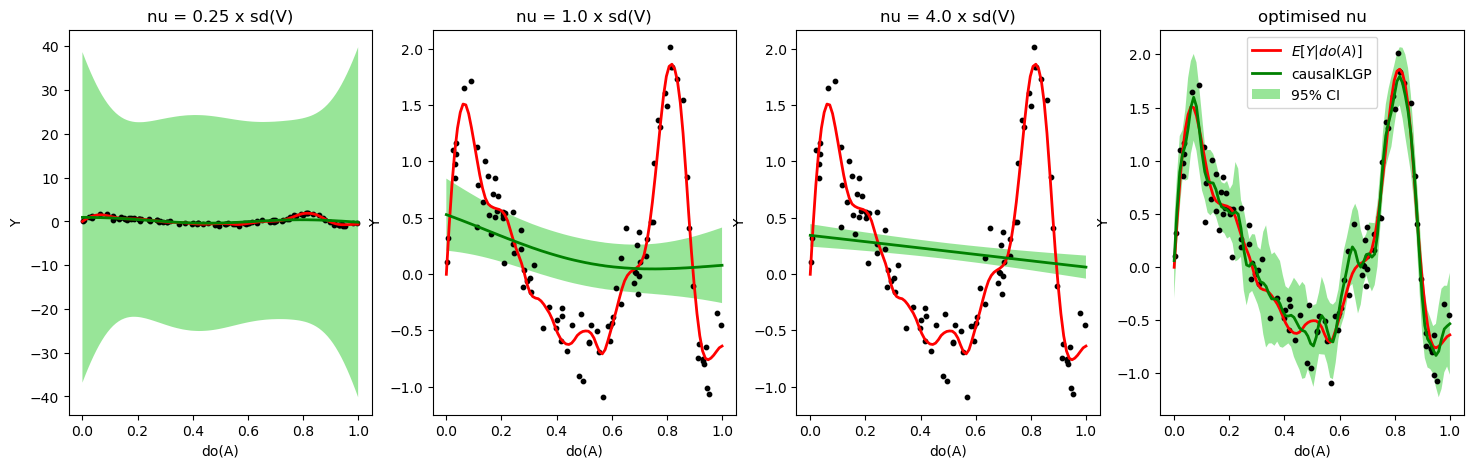

In [8]:
# Getting posterior moments and plotting results
power_list = torch.linspace(-2,2,3)
nulist = list(2**power_list)
nulist.append(1.0)

fig,axs = plt.subplots(1,len(nulist),figsize = (18,5))


Bayesimp_mu = []
Bayesimp_var = []
Bayesimp_var_noise = []

for k in range(len(nulist)):
    

    """Initialising model"""
    model = BayesIMP(Kernel_A = GaussianKernel, 
                   Kernel_V = GaussianKernel, 
                   Kernel_Z = [],
                   dim_A = A.size()[1], 
                   dim_V = V.size()[1], 
                   samples = 10**5,
                   exact = exact)

    """ Training full model """
    model.train(Y,A,V,niter,learn_rate, optimise_measure = k == len(nulist)-1, measure_init = nulist[k], mc_samples = 100)
        
    # getting post mean predictions
    Bayesimp = deepcopy(model)
    bayesimp_mu = Bayesimp.post_mean(Y, A, V, doA).detach()
    bayesimp_var = Bayesimp.post_var(Y, A, V, doA, reg = 1e-4, latent = True).detach()
    bayesimp_var_noise = Bayesimp.post_var(Y, A, V, doA, reg = 1e-4, latent = False).detach()
    
    # Getting CI
    indices = torch.argsort(doA,0)[:,0]
    indices_train = torch.argsort(A,0)[:,0]
    Upper = (bayesimp_mu[indices]+z_val*torch.sqrt(bayesimp_var[indices]))
    Lower = (bayesimp_mu[indices]-z_val*torch.sqrt((bayesimp_var[indices])))
    Upper_noise = (bayesimp_mu[indices]+z_val*torch.sqrt((bayesimp_var_noise[indices])))
    Lower_noise = (bayesimp_mu[indices]-z_val*torch.sqrt((bayesimp_var_noise[indices])))
    
    axs[k].plot(doA[indices],EYdoA[indices], label = r"$ E[Y|do(A)]$", color = "red", linewidth = 2)
    axs[k].plot(doA[indices],bayesimp_mu[indices], label = r"causalKLGP", color = "green", linewidth = 2)
    #axs[k].fill_between(doA[indices][:,0],Upper_noise,Lower_noise, color = "lightgreen",alpha=0.5, edgecolor='none', label = "95% CI")
    axs[k].fill_between(doA[indices][:,0],Upper[:,0],Lower[:,0], color = "limegreen",alpha=0.5, edgecolor='none', label = "95% CI")
    #axs[k].scatter(doA[indices],YdoA[indices], label = r"$ Y|do(A)$", color = "grey", s=10, alpha = 1)
    axs[k].scatter(A,Y, s = 10, color = "black")
    axs[k].set_xlabel("do(A)")
    axs[k].set_ylabel("Y")
    if k != len(nulist)-1:
        axs[k].set_title("nu = " + str((2**power_list[k]).item())+" x sd(V)")
    else:
        axs[k].set_title("optimised nu")
        
    Bayesimp_mu.append(bayesimp_mu)
    Bayesimp_var.append(bayesimp_var)
    Bayesimp_var_noise.append(bayesimp_var_noise)
    
plt.legend()
plt.show()

/tmp/ipykernel_605080/2342958399.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()


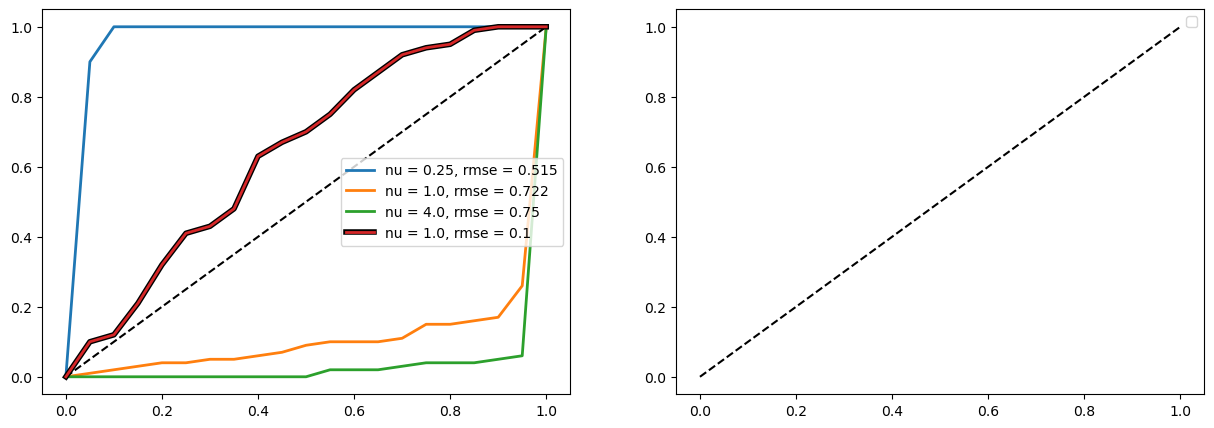

In [9]:
# Getting calibration plots
outline=mpe.withStroke(linewidth=4, foreground='black')
def _round(x, n):
    return int(x*10**n)/10**n

fig, axs = plt.subplots(1,2,figsize = (15,5))
levels = torch.linspace(0,1,21)[:,None]
z_quantiles = Normal(0, 1).icdf(1-(1-levels)/2)
axs[0].plot(levels, levels, ls = "dashed", color = "black")
axs[1].plot(levels, levels, ls = "dashed", color = "black")

for k in range(len(nulist)):
    
    # getting post mean predictions
    mean = Bayesimp_mu[k]
    var = Bayesimp_var[k]
    var_noise = Bayesimp_var_noise[k]

    # Restricting to in sample distribution
    inds = ((doA[:,0]<=1)*(doA[:,0]>=0))
    
    posterior_fraction_f = ((EYdoA[inds] - mean[inds]).abs() <= var[inds]**0.5 @ z_quantiles.T).float().mean(0)
    posterior_fraction_y = ((YdoA[inds,None] - mean[inds]).abs() <= var_noise[inds]**0.5 @ z_quantiles.T).float().mean(0)
    rmse = ((EYdoA[inds] - mean[inds])**2).mean()**0.5

    axs[0].plot(levels,posterior_fraction_f, label = "nu = {0}, rmse = {1}".format(_round(nulist[k],3), _round(rmse,3)), lw = 2, path_effects = [outline]*(k == len(nulist)-1))
    axs[0].legend()
    axs[1].legend()